In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load dataset
data = pd.read_csv('data/spotify_cleaned.csv')
print(data.info())

# Feature columns
feature_cols = [
    "track_popularity",
    "danceability",
    "energy",
    "valence",
    "tempo",
    "acousticness",
    "instrumentalness",
    "liveness",
    "speechiness",
    "loudness"
]

# Feature matrix
X = data[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

#X_scaled[:, feature_cols.index("track_popularity")]*=2  # Scale popularity

# Neighbor finder
nn_model = NearestNeighbors(
    n_neighbors=50,
    metric='cosine',
    algorithm='brute'
)
nn_model.fit(X_scaled)
print("KNN model trained and ready.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19419 entries, 0 to 19418
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  19419 non-null  object 
 1   track_name                19419 non-null  object 
 2   track_artist              19419 non-null  object 
 3   track_popularity          19419 non-null  int64  
 4   track_album_id            19419 non-null  object 
 5   track_album_name          19419 non-null  object 
 6   track_album_release_date  19419 non-null  object 
 7   playlist_name             19419 non-null  float64
 8   playlist_id               19419 non-null  object 
 9   playlist_genre            19419 non-null  object 
 10  playlist_subgenre         19419 non-null  float64
 11  danceability              19419 non-null  float64
 12  energy                    19419 non-null  float64
 13  key                       19419 non-null  int64  
 14  loudne

In [3]:
# Clean row indices
data = data.reset_index(drop=True)

In [4]:
def find_song_indices(df, track_name=None, track_artist=None):
    mask = pd.Series(True, index=df.index)

    if track_name is not None:
        mask &= df["track_name"].str.contains(
            track_name,
            case=False,
            na=False,
            regex=False,   
        )

    if track_artist is not None:
        mask &= df["track_artist"].str.contains(
            track_artist,
            case=False,
            na=False,
            regex=False,
        )

    return df[mask].index.tolist()


In [5]:
def recommend_knn(song_queries, data, X_scaled, total_top_k=20):
    all_recs = []
    seen_pairs = set()

    # 1) Collect ALL seed indices (to exclude them from recs)
    exclude_indices = []
    for q in song_queries:
        tname = q.get("track_name")
        aname = q.get("track_artist")
        matches = find_song_indices(data, track_name=tname, track_artist=aname)
        exclude_indices.extend(matches)
    exclude_indices = set(exclude_indices)

    # 2) For each seed, gather candidate neighbors
    for q in song_queries:
        tname = q.get("track_name")
        aname = q.get("track_artist")

        seed_matches = find_song_indices(data, track_name=tname, track_artist=aname)
        if not seed_matches:
            print(f"No match found for: {tname} - {aname}")
            continue

        for seed_idx in seed_matches:
            seed_vector = X_scaled[seed_idx].reshape(1, -1)
            # ask for a bit more neighbors to account for exclusions
            distances, indices = nn_model.kneighbors(
                seed_vector,
                n_neighbors=total_top_k + len(exclude_indices) + 10
            )

            for dist, idx in zip(distances[0], indices[0]):
                if idx in exclude_indices:
                    continue

                track_name = data.at[idx, "track_name"]
                track_artist = data.at[idx, "track_artist"]
                pair = (track_name, track_artist)

                if pair in seen_pairs:
                    continue

                seen_pairs.add(pair)
                all_recs.append({
                    "track_name": track_name,
                    "track_artist": track_artist,
                    "distance": dist
                })

    if not all_recs:
        return pd.DataFrame(columns=["track_name", "track_artist", "distance",
                                     "seed_track_name", "seed_track_artist"])

    # 3) Global cap: keep closest songs overall
    all_recs = (
        pd.DataFrame(all_recs)
        .sort_values("distance")
        .head(total_top_k)
        .reset_index(drop=True)
    )
    return all_recs

In [6]:
# Display plot of all neighbors global sample song of all feature space
# Display dot plot of song neighbors
def plot_song_neighbors(user_songs, X_scaled, nn_model, feature_cols):
    for song in user_songs:
        tname = song.get("track_name")
        aname = song.get("track_artist")

        seed_matches = find_song_indices(data, track_name=tname, track_artist=aname)
        if not seed_matches:
            print(f"No match found for: {tname} - {aname}")
            continue

        seed_idx = seed_matches[0]
        seed_vector = X_scaled[seed_idx].reshape(1, -1)
        distances, indices = nn_model.kneighbors(seed_vector, n_neighbors=10)

        neighbor_indices = indices[0]
        neighbor_distances = distances[0]

        plt.figure(figsize=(10, 6))
        for i, feature in enumerate(feature_cols):
            plt.scatter(
                [i] * len(neighbor_indices),
                X_scaled[neighbor_indices, i],
                s=100,
                alpha=0.6,
                label='Neighbors' if i == 0 else ""
            )
            plt.scatter(
                i,
                X_scaled[seed_idx, i],
                color='red',
                s=200,
                marker='X',
                label='Seed Song' if i == 0 else ""
            )

        plt.xticks(range(len(feature_cols)), feature_cols, rotation=45)
        plt.title(f"Feature Space Neighbors for '{data.at[seed_idx, 'track_name']}' by {data.at[seed_idx, 'track_artist']}")
        plt.ylabel("Standardized Feature Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [7]:
# Compute cosine similarity score between user songs and recommended songs
def cosine_similarity_score(user_songs, recommended_songs):
    user_indices = []
    rec_indices = []
    for song in user_songs:
        tname = song.get("track_name")
        aname = song.get("track_artist")
        matches = find_song_indices(data, track_name=tname, track_artist=aname)
        if matches:
            user_indices.append(matches[0])
    for _, row in recommended_songs.iterrows():
        matches = find_song_indices(data, track_name=row["track_name"], track_artist=row["track_artist"])
        if matches:
            rec_indices.append(matches[0])
    if not user_indices or not rec_indices:
        return None
    user_vectors = X_scaled[user_indices]
    rec_vectors = X_scaled[rec_indices]
    sim_matrix = cosine_similarity(user_vectors, rec_vectors)
    return sim_matrix

No match found for: Don't you forget about me - Simple Minds
                                          track_name       track_artist  \
0                                         Last Child          Aerosmith   
1         Burning Heart - From "Rocky IV" Soundtrack           Survivor   
2                Into You (feat. Tamia) - Radio Edit           Fabolous   
3                                    I Adore Mi Amor      Color Me Badd   
4                        P.D.A. (We Just Don't Care)        John Legend   
5                                  Satellite of Love           Lou Reed   
6                              Deixa Eu Te Encontrar       Julia Sicone   
7                              Cum on Feel the Noize         Quiet Riot   
8  The Night They Drove Old Dixie Down - Remaster...           The Band   
9            It Never Rains (In Southern California)  Tony! Toni! Toné!   

   distance  
0  0.036683  
1  0.037401  
2  0.048346  
3  0.054926  
4  0.059166  
5  0.060547  
6  0.060618  
7

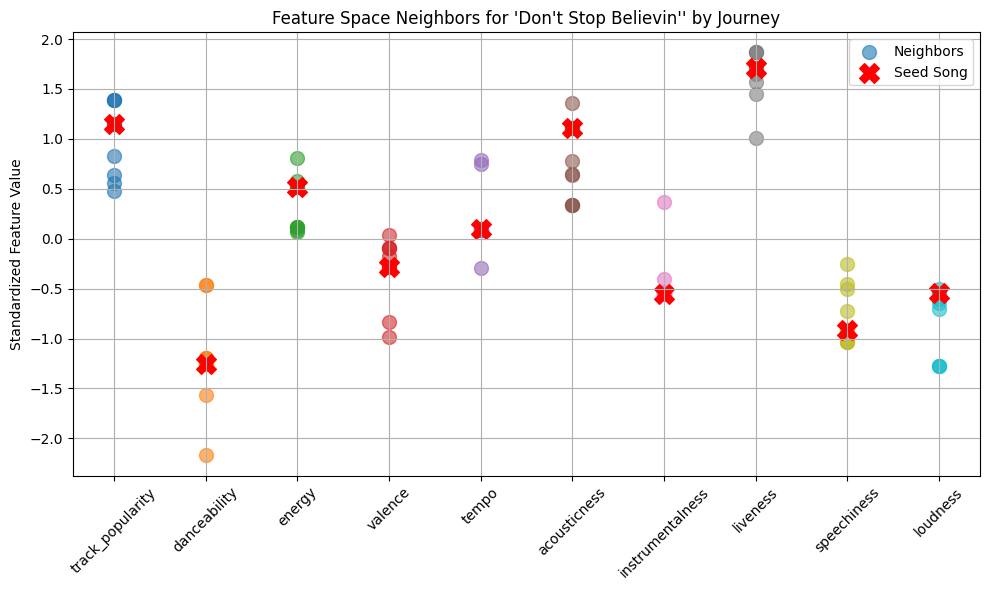

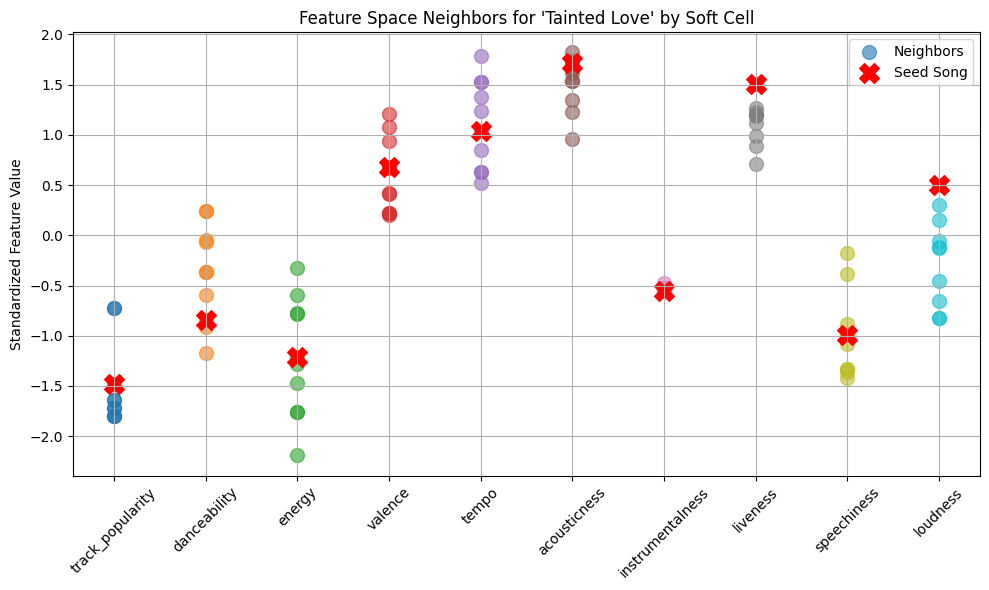

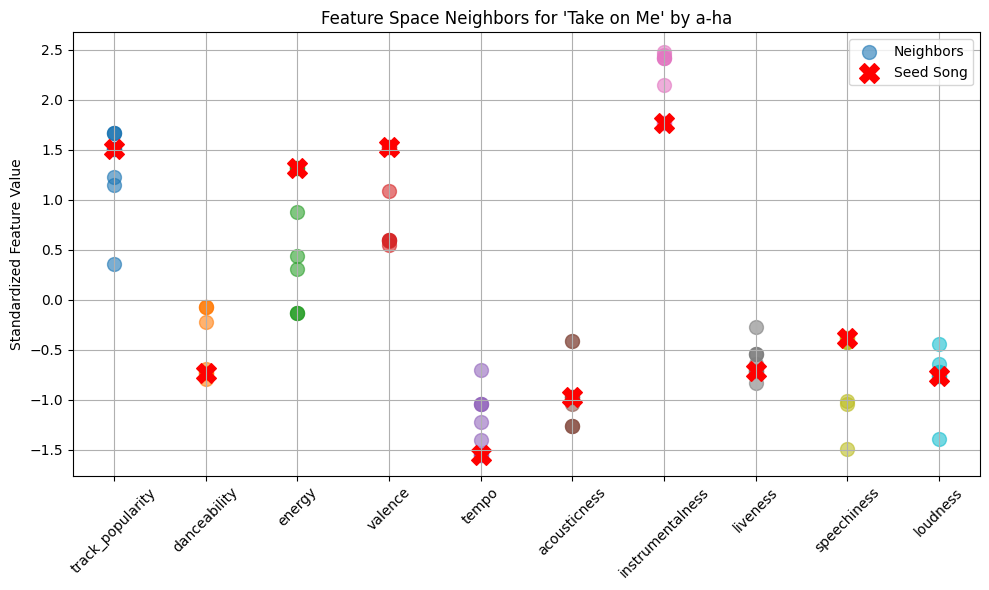

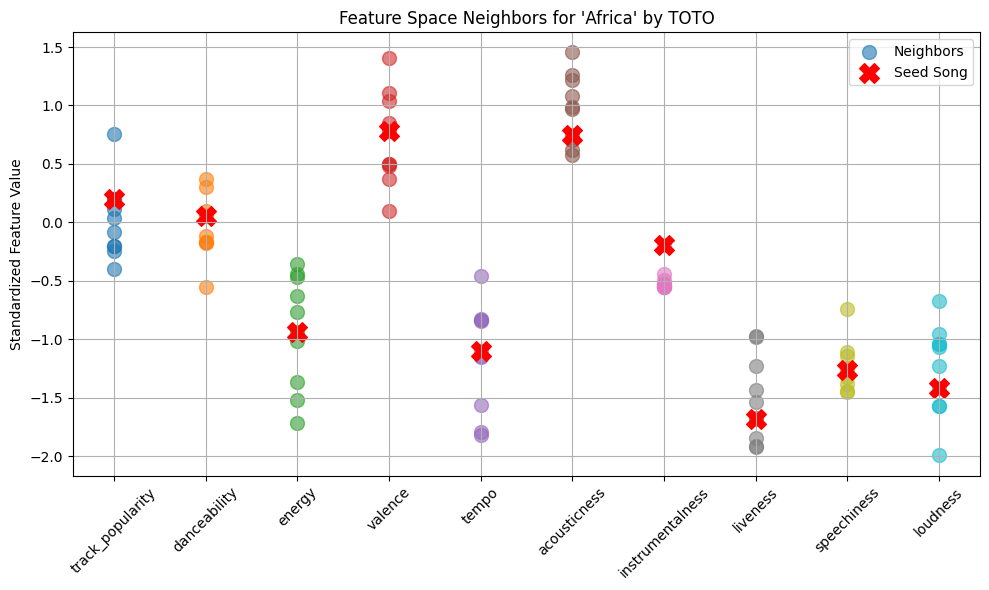

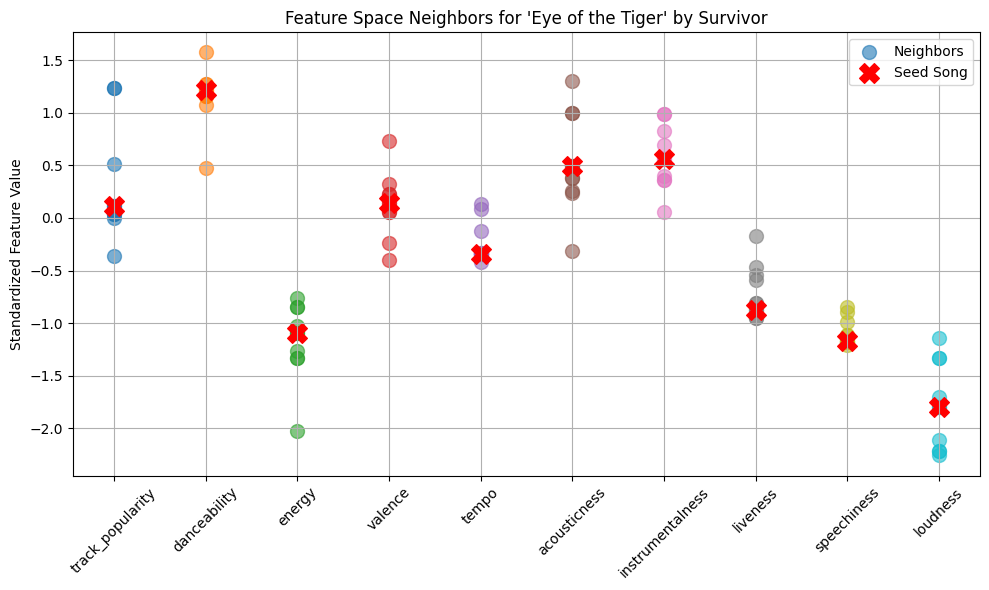

Recommendation: Last Child - Aerosmith, Cosine Similarity Score Mean: 0.3858
Recommendation: Burning Heart - From "Rocky IV" Soundtrack - Survivor, Cosine Similarity Score Mean: 0.3638
Recommendation: Into You (feat. Tamia) - Radio Edit - Fabolous, Cosine Similarity Score Mean: 0.3339
Recommendation: I Adore Mi Amor - Color Me Badd, Cosine Similarity Score Mean: 0.4254
Recommendation: P.D.A. (We Just Don't Care) - John Legend, Cosine Similarity Score Mean: 0.1303
Recommendation: Satellite of Love - Lou Reed, Cosine Similarity Score Mean: 0.3895
Recommendation: Deixa Eu Te Encontrar - Julia Sicone, Cosine Similarity Score Mean: 0.2996
Recommendation: Cum on Feel the Noize - Quiet Riot, Cosine Similarity Score Mean: -0.1741
Recommendation: The Night They Drove Old Dixie Down - Remastered 2000 - The Band, Cosine Similarity Score Mean: 0.3533
Recommendation: It Never Rains (In Southern California) - Tony! Toni! Toné!, Cosine Similarity Score Mean: 0.3326


In [14]:
# Example usage
user_songs = [
    {"track_name": "Don't you forget about me", "track_artist": "Simple Minds"},
    {"track_name": "Don't stop believin'", "track_artist": "Journey"},
    {"track_name": "Tainted Love", "track_artist": "Soft Cell"},
    {"track_name": "Take on Me", "track_artist": "a-ha"},
    {"track_name": "Africa", "track_artist": "Toto"},
    {"track_name": "Eye of the Tiger", "track_artist": "Survivor"},
]
recs = recommend_knn(
    song_queries=user_songs,
    data=data,
    X_scaled=X_scaled,
    total_top_k=10
)

print(recs)
plot_song_neighbors(user_songs, X_scaled, nn_model, feature_cols)
sim_matrix = cosine_similarity_score(user_songs, recs)
if sim_matrix is not None:
    sim_means = sim_matrix.mean(axis=0)
    for i, row in recs.iterrows():
        print(f"Recommendation: {row['track_name']} - {row['track_artist']}, Cosine Similarity Score Mean: {sim_means[i]:.4f}")

In [9]:
import random 
# Backtest playlist
def backtest_playlist(playlistname, seed=.8, n_rec=10):
    # Load playlist data with error handling for malformed CSV
    playlist_df = pd.read_csv('data/spotify_playlists.csv', on_bad_lines='skip', engine='python')
    
    # Convert playlistname column to string to avoid float/type issues
    playlist_df['playlistname'] = playlist_df['playlistname'].astype(str)

    # List of tuples (track_name, track_artist) for all songs in the playlist
    playlist_songs = list(
        playlist_df[playlist_df['playlistname'] == str(playlistname)][['trackname', 'artistname']].itertuples(index=False, name=None)
    )

    songCount = len(playlist_songs)
    
    # Remove songs not in data
    valid_songs = []
    for track_name, track_artist in playlist_songs:
        matches = find_song_indices(data, track_name=track_name, track_artist=track_artist)
        if matches:
            valid_songs.append((track_name, track_artist))

    validCount = len(valid_songs)

    # remove seed songs randomly
    seed_songs = random.sample(valid_songs, min(int(np.floor(validCount*seed)), validCount))

    # remove seed songs from valid songs
    for song in seed_songs:
        valid_songs.remove(song)

    # Prepare song queries for recommendation
    song_queries = [
        {"track_name": track_name, "track_artist": track_artist}
        for track_name, track_artist in seed_songs
    ]

    recs = recommend_knn(
        song_queries=song_queries,
        data=data,
        X_scaled=X_scaled,
        total_top_k=n_rec
    )

    display(recs)

    # Print summary
    print(f"\nBacktest Summary for Playlist: {playlistname}")
    print(f"Total songs in playlist: {songCount}")
    print(f"Valid songs in dataset: {validCount}")
    print(f"Seed songs used: {len(seed_songs)}")
    print(f"Recommendations generated: {len(recs)}")

    # Calculate how many recommendations were actually in the original playlist
    rec_in_playlist = 0
    for _, row in recs.iterrows():
        if (row['track_name'], row['track_artist']) in valid_songs:
            rec_in_playlist += 1


    print(f"Recommendations in original playlist: {rec_in_playlist}")

In [10]:
backtest_playlist('Songs I Need', .8, 50)

,track_name,track_artist,distance
0,Fallen Leaves,Billy Talent,0.023052
1,Total Eclipse Of The Heart (Glee Cast Version)...,Glee Cast,0.029114
2,Be Somebody,Kings of Leon,0.033189
3,Changes,Imagination,0.034387
4,The End of the River,オメガトライブ,0.034640
5,Locos por Mi Habana - Remasterizado,Manolito Simonet y su Trabuco,0.037114
6,Scotty Doesn't Know,Lustra,0.037500
7,How Did It Come to This?,Arena,0.039749
8,Down Under,Love Canon,0.039979
9,Rhythm & Blues,The Head and the Heart,0.040591



Backtest Summary for Playlist: Songs I Need
Total songs in playlist: 367
Valid songs in dataset: 52
Seed songs used: 41
Recommendations generated: 50
Recommendations in original playlist: 0


In [11]:
backtest_playlist('chill out', .8, 50)

,track_name,track_artist,distance
0,Estoy Aquí,Shakira,0.019686
1,Money Ain't A Thang,JAY-Z,0.020471
2,Games,Chris River,0.023546
3,Heaven Is a Place on Earth,Belinda Carlisle,0.026031
4,Me and You and a Dog Named Boo,Lobo,0.026172
5,El Taxi,Pitbull,0.028666
6,Ventura Highway,America,0.030221
7,Changes - 2015 Remaster,David Bowie,0.034491
8,I Don't Know,Slush The Villain,0.035038
9,Better in Stereo - Theme Song Version,Dove Cameron,0.035846



Backtest Summary for Playlist: chill out
Total songs in playlist: 204
Valid songs in dataset: 23
Seed songs used: 18
Recommendations generated: 50
Recommendations in original playlist: 0


In [12]:
backtest_playlist('Liked from Radio', .8, 50)

KeyboardInterrupt: 